<a href="https://colab.research.google.com/github/Rene-Castillo-21/Proyecto-1-Redes-Neuronales-Recurrentes-/blob/main/Proyecto_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción de Temperatura con Redes Neuronales Recurrentes (GRU)

### Este proyecto implementa un modelo de aprendizaje profundo para predecir series temporales de temperatura utilizando una arquitectura GRU. Incluye un análisis exploratorio de datos, preprocesamiento, y evaluación comparativa contra un modelo base.

# Configuración Inicial

### Importación de bibliotecas esenciales para el procesamiento de datos, visualización y modelado

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

# Carga y Exploración de Datos

### Utilizamos datos meteorológicos de Delhi para predecir la temperatura media

In [14]:
# Cargar dataset
data = pd.read_csv('DailyDelhiClimateTest.csv')

# Visualización inicial del dataset
print("Primeras muestras del dataset:")
print(data.head())
print("\nResumen estadístico:")
print(data.describe())


Primeras muestras del dataset:
         date   meantemp   humidity  wind_speed  meanpressure
0  2017-01-01  15.913043  85.869565    2.743478     59.000000
1  2017-01-02  18.500000  77.222222    2.894444   1018.277778
2  2017-01-03  17.111111  81.888889    4.016667   1018.333333
3  2017-01-04  18.700000  70.050000    4.545000   1015.700000
4  2017-01-05  18.388889  74.944444    3.300000   1014.333333

Resumen estadístico:
         meantemp    humidity  wind_speed  meanpressure
count  114.000000  114.000000  114.000000    114.000000
mean    21.713079   56.258362    8.143924   1004.035090
std      6.360072   19.068083    3.588049     89.474692
min     11.000000   17.750000    1.387500     59.000000
25%     16.437198   39.625000    5.563542   1007.437500
50%     19.875000   57.750000    8.069444   1012.739316
75%     27.705357   71.902778   10.068750   1016.739583
max     34.500000   95.833333   19.314286   1022.809524


# Análisis Exploratorio de Datos (EDA)


Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          114 non-null    object 
 1   meantemp      114 non-null    float64
 2   humidity      114 non-null    float64
 3   wind_speed    114 non-null    float64
 4   meanpressure  114 non-null    float64
dtypes: float64(4), object(1)
memory usage: 4.6+ KB

Valores faltantes por columna:
date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64


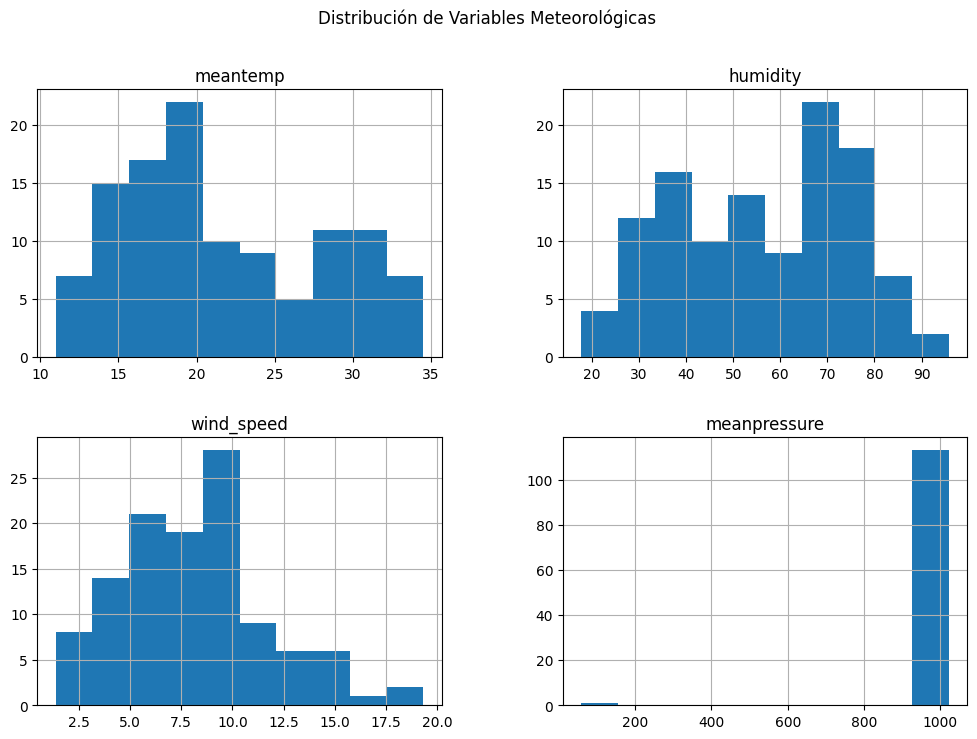

In [15]:
# Estructura del Dataset
print("\nInformación del dataset:")
data.info()

# Valores Faltantes
print("\nValores faltantes por columna:")
print(data.isna().sum())

# Distribución de Variables
data.hist(figsize=(12, 8))
plt.suptitle('Distribución de Variables Meteorológicas')
plt.show()


# Preprocesamiento de Datos

In [17]:
# Eliminación de Columna Temporal
# La fecha no se utiliza directamente en el modelo
data = data.drop(["date"], axis=1)

# Normalización de Datos
# Escalado de características al rango [0,1] para mejorar el rendimiento de la red neuronal
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)

# Preparación de Datos para Series Temporales

In [18]:
# Creación de secuencias temporales para el modelo de aprendizaje supervisado

def create_sequences(dataset, look_back=60):
    """
    Crea secuencias temporales para entrenamiento de modelos RNN.

    Parámetros:
    dataset - Datos normalizados
    look_back - Número de pasos temporales a considerar para cada predicción

    Retorna:
    Tuplas (X, y) para entrenamiento, validación y prueba
    """
    X, y = [], []
    total_size = len(dataset) - look_back

    for i in range(total_size):
        seq = dataset[i:(i + look_back), :]
        target = dataset[i + look_back, 3]  # La columna 3 corresponde a 'meantemp'
        X.append(seq)
        y.append(target)

    # División en conjuntos de entrenamiento (80%), validación (10%) y prueba (10%)
    train_size = int(total_size * 0.8)
    val_size = int(total_size * 0.9)

    X_train = np.array(X[:train_size])
    y_train = np.array(y[:train_size])

    X_val = np.array(X[train_size:val_size])
    y_val = np.array(y[train_size:val_size])

    X_test = np.array(X[val_size:])
    y_test = np.array(y[val_size:])

    return X_train, y_train, X_val, y_val, X_test, y_test

# Creación de secuencias con ventana de 60 epochs
X_train, y_train, X_val, y_val, X_test, y_test = create_sequences(data_normalized)


# Modelo de Referencia (Naive)

In [19]:
# Establece una línea base usando el último valor conocido como predicción

def evaluate_naive():
    """
    Evalúa un modelo simple que siempre predice el último valor conocido.
    """
    naive_predictions = X_train[:, -1, 3]  # Último valor de temperatura en cada secuencia
    mae = np.mean(np.abs(naive_predictions - y_train))
    print(f'MAE (Error Absoluto Medio) del modelo naive: {mae:.4f}')

evaluate_naive()

MAE del modelo naive: 0.0015


# Modelo GRU para Predicción Temporal

Epoch 1/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 1.2259 - val_loss: 0.9695
Epoch 2/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.9707 - val_loss: 0.6944
Epoch 3/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.7154 - val_loss: 0.4003
Epoch 4/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.4364 - val_loss: 0.4672
Epoch 5/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.4403 - val_loss: 0.5658
Epoch 6/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.5103 - val_loss: 0.5228


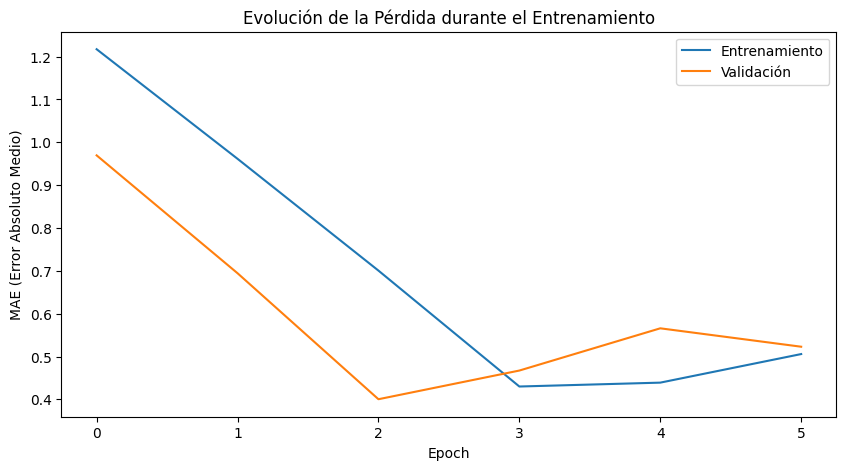

In [25]:
# Configuración del Modelo
# Arquitectura GRU con regularización para prevenir sobreajuste
model = Sequential([
    GRU(32,
        return_sequences=True,
        input_shape=(None, X_train.shape[2]),
        recurrent_dropout=0.4,
        kernel_regularizer=l2(0.005)),
    GRU(64,
        recurrent_dropout=0.4,
        kernel_regularizer=l2(0.005)),
    Dense(1)
])

# Compilación y Entrenamiento
model.compile(optimizer=Adam(), loss='mae')

# Early Stopping para detener entrenamiento cuando no hay mejora
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=60,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

# Visualización del Proceso de Entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Evolución de la Pérdida durante el Entrenamiento')
plt.ylabel('MAE (Error Absoluto Medio)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Evaluación y Visualización de Resultados

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


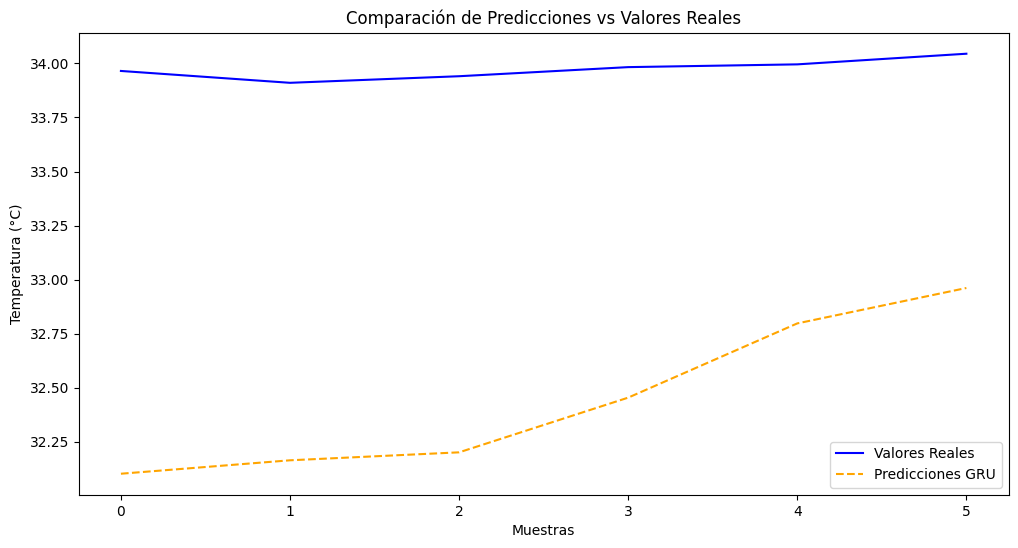

In [21]:
# Predicciones en el Conjunto de Prueba
predictions = model.predict(X_test)

# Inversión de la Normalización
# Recuperamos las escalas originales para interpretación
temp_min = data['meantemp'].min()
temp_max = data['meantemp'].max()

# Función para revertir normalización
def inverse_transform(normalized_data):
    return normalized_data * (temp_max - temp_min) + temp_min

y_test_orig = inverse_transform(y_test)
predictions_orig = inverse_transform(predictions)

# Visualización Comparativa
plt.figure(figsize=(12, 6))
plt.plot(y_test_orig, label='Valores Reales', color='blue')
plt.plot(predictions_orig, label='Predicciones GRU', color='orange', linestyle='--')
plt.title('Comparación de Predicciones vs Valores Reales')
plt.xlabel('Muestras')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.show()